## Finetune Mask RCNN baseline comparison model

### **Install Detectron2**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core

!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 5.6 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Cloning into 'detectron2'...
remote: Enumerating objects: 15730, done.
remote: Counting objects: 100% (453/453), done.
remote: Compressing objects: 100% (331/331), done.
remote: Total 15730 (delta 206), reused 299 (delta 113), pack-reused 15277
Receiving objects: 100% (15730/15730), 6.51 MiB | 15.96 MiB/s, done.
Resolving deltas: 100% (11321/11321), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.0 MB/s eta 0:0

In [ ]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.3 ; cuda:  cu121
detectron2: 0.6


In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

Import the necessary function to register datasets in the COCO format. Let us register both the training and validation datasets.

Our dataset has been preprocessed into coco format where we have a single JSON file that describes all the annotations from all training images. <p>

Here, we are naming our training data as 'my_dataset_train' and the validation data as 'my_dataset_val'.



We have preprocessed our images into a coco json format in the preprocessing notebook. So we just import them directly here

In [ ]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "/content/drive/MyDrive/Final IDCC-SAM/Rebuttal/VGG/Mask RCNN/COCO_dataset/train/coco_annotations.json", "/content/drive/MyDrive/Final IDCC-SAM/Rebuttal/VGG/Mask RCNN/COCO_dataset/train")
register_coco_instances("my_dataset_val", {}, "/content/drive/MyDrive/Final IDCC-SAM/Rebuttal/VGG/Mask RCNN/COCO_dataset/val/coco_annotations.json", "/content/drive/MyDrive/Final IDCC-SAM/Rebuttal/VGG/Mask RCNN/COCO_dataset/val")

Let us extract the metadata and dataset dictionaries for both training and validation datasets.

In [ ]:
train_metadata = MetadataCatalog.get("my_dataset_train")
train_dataset_dicts = DatasetCatalog.get("my_dataset_train")

[06/21 00:14:41 d2.data.datasets.coco]: Loading /content/drive/MyDrive/Final IDCC-SAM/Rebuttal/VGG/Mask RCNN/COCO_dataset/train/coco_annotations.json takes 3.82 seconds.
[06/21 00:14:41 d2.data.datasets.coco]: Loaded 128 images in COCO format from /content/drive/MyDrive/Final IDCC-SAM/Rebuttal/VGG/Mask RCNN/COCO_dataset/train/coco_annotations.json


In [ ]:
val_metadata = MetadataCatalog.get("my_dataset_val")
val_dataset_dicts = DatasetCatalog.get("my_dataset_val")

[06/21 00:15:34 d2.data.datasets.coco]: Loading /content/drive/MyDrive/Final IDCC-SAM/Rebuttal/VGG/Mask RCNN/COCO_dataset/val/coco_annotations.json takes 1.74 seconds.
[06/21 00:15:34 d2.data.datasets.coco]: Loaded 32 images in COCO format from /content/drive/MyDrive/Final IDCC-SAM/Rebuttal/VGG/Mask RCNN/COCO_dataset/val/coco_annotations.json


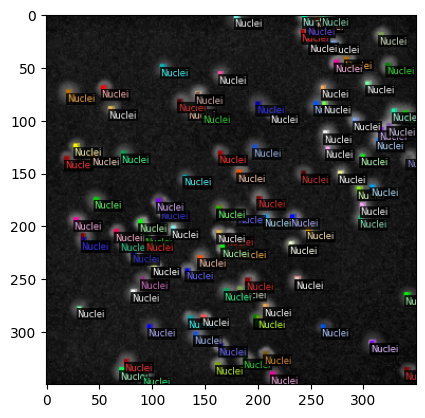

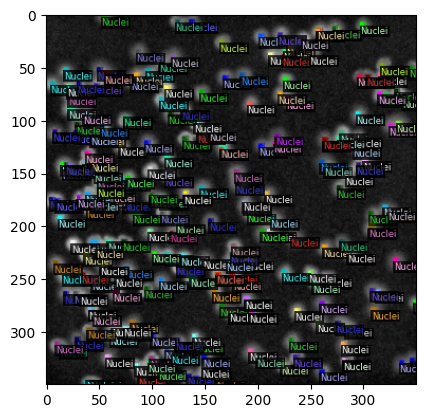

In [ ]:
from matplotlib import pyplot as plt
# Visualize a random sample
for d in random.sample(train_dataset_dicts, 2):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image()[:, :, ::-1])
    plt.show()

# Train

Now we are ready to train a Mask R-CNN model using the Detectron2 library. We start by setting up a configuration file (.cfg) for the model training.

For the purpose of our fine-tuning, we use the default settings mostly. Main modifications is the number of classes.

In [ ]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.OUTPUT_DIR = "/content/drive/MyDrive/ColabNotebooks/models/Detectron2_Models"
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 500
cfg.SOLVER.STEPS = []
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # We have 1 classes, nuclei
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) #Create an instance of of DefaultTrainer with the given configuration
trainer.resume_or_load(resume=False) #Load a pretrained model if available (resume training) or start training from scratch if no pretrained model is available

[06/21 00:16:07 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:00, 232MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


Train

In [ ]:
trainer.train() #Start the training process

[06/21 00:16:22 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.10/dist-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(
/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(
/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan fai

[06/21 00:16:44 d2.utils.events]:  eta: 0:06:39  iter: 19  total_loss: 7.409  loss_cls: 0.5992  loss_box_reg: 0.02104  loss_mask: 0.6916  loss_rpn_cls: 4.367  loss_rpn_loc: 1.821    time: 0.8727  last_time: 1.3048  data_time: 0.3802  last_data_time: 0.8515   lr: 9.7405e-06  max_mem: 2618M


/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(
/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(


[06/21 00:17:06 d2.utils.events]:  eta: 0:06:12  iter: 39  total_loss: 3.801  loss_cls: 0.5487  loss_box_reg: 0.01044  loss_mask: 0.6906  loss_rpn_cls: 0.8509  loss_rpn_loc: 1.739    time: 0.8709  last_time: 1.1561  data_time: 0.3588  last_data_time: 0.6401   lr: 1.9731e-05  max_mem: 2654M


/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(
/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(
/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(
/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed wi

[06/21 00:17:23 d2.utils.events]:  eta: 0:05:41  iter: 59  total_loss: 3.114  loss_cls: 0.4565  loss_box_reg: 0.006784  loss_mask: 0.6898  loss_rpn_cls: 0.4176  loss_rpn_loc: 1.532    time: 0.8535  last_time: 0.7269  data_time: 0.3326  last_data_time: 0.2180   lr: 2.972e-05  max_mem: 2654M


/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(


[06/21 00:17:35 d2.utils.events]:  eta: 0:05:03  iter: 79  total_loss: 2.466  loss_cls: 0.5048  loss_box_reg: 0.04526  loss_mask: 0.6878  loss_rpn_cls: 0.3798  loss_rpn_loc: 0.8514    time: 0.7950  last_time: 0.5412  data_time: 0.0778  last_data_time: 0.0128   lr: 3.9711e-05  max_mem: 2687M


/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(


[06/21 00:17:46 d2.utils.events]:  eta: 0:04:33  iter: 99  total_loss: 2.193  loss_cls: 0.5374  loss_box_reg: 0.179  loss_mask: 0.6855  loss_rpn_cls: 0.3182  loss_rpn_loc: 0.4772    time: 0.7461  last_time: 0.6518  data_time: 0.0147  last_data_time: 0.0311   lr: 4.9701e-05  max_mem: 2687M
[06/21 00:17:57 d2.utils.events]:  eta: 0:04:08  iter: 119  total_loss: 2.116  loss_cls: 0.533  loss_box_reg: 0.2317  loss_mask: 0.6823  loss_rpn_cls: 0.2856  loss_rpn_loc: 0.3632    time: 0.7114  last_time: 0.5246  data_time: 0.0127  last_data_time: 0.0068   lr: 5.9691e-05  max_mem: 2687M
[06/21 00:18:08 d2.utils.events]:  eta: 0:03:44  iter: 139  total_loss: 2.11  loss_cls: 0.5369  loss_box_reg: 0.3162  loss_mask: 0.6798  loss_rpn_cls: 0.2814  loss_rpn_loc: 0.3214    time: 0.6886  last_time: 0.5141  data_time: 0.0145  last_data_time: 0.0098   lr: 6.9681e-05  max_mem: 2687M
[06/21 00:18:20 d2.utils.events]:  eta: 0:03:29  iter: 159  total_loss: 2.081  loss_cls: 0.5422  loss_box_reg: 0.3257  loss_mask

Save the config file

In [ ]:
import yaml
# Save the configuration to a config.yaml file
config_yaml_path = "/content/drive/MyDrive/ColabNotebooks/models/Detectron2_Models/config.yaml"
with open(config_yaml_path, 'w') as file:
    yaml.dump(cfg, file)

# Inference & evaluation using the trained model

In [ ]:
# Inference should use the config with parameters that are used in training
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.20   # set a custom testing threshold. We tried 10, 20, 30, 40, 50; 20 had the best performance.
cfg.TEST.DETECTIONS_PER_IMAGE = 2000  # Set the maximum number of detections per image to 2000 (this accomodate our image context well. The most dense image in our dataset is not up to 1000 cells)
predictor = DefaultPredictor(cfg)

[06/21 00:24:40 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/ColabNotebooks/models/Detectron2_Models/model_final.pth ...


#### Verify segmentation on random validation images

/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(


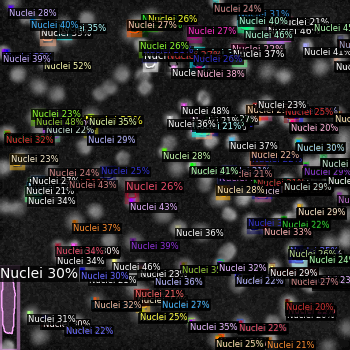

In [ ]:
from detectron2.utils.visualizer import ColorMode

for d in random.sample(val_dataset_dicts, 1):    #select number of images for display
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=val_metadata,
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE_BW)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

###**Load a Test image and segment it.**

[06/21 00:27:26 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/ColabNotebooks/models/Detectron2_Models/model_final.pth ...


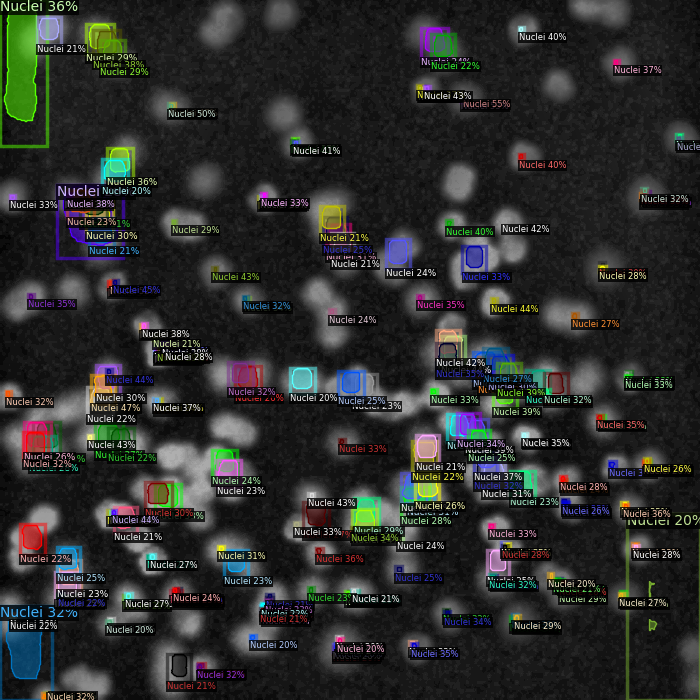

Number of instance predictions: 242


In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.20   # set a custom testing threshold. We tried 10, 20, 30, 40, 50; The performance deteriorates after 20.
cfg.TEST.DETECTIONS_PER_IMAGE = 2000

predictor = DefaultPredictor(cfg)

new_im = cv2.imread("/content/drive/MyDrive/Final IDCC-SAM/Dataset/Rebuttal/VGG/Test_clahe/images/161cell.png")
outputs  = predictor(new_im)

# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(new_im[:, :, ::-1], metadata=train_metadata)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

cv2_imshow(out.get_image()[:, :, ::-1])

# Get the instance predictions
instances = outputs["instances"]

# Get the number of instance predictions
num_predictions = len(instances)

print("Number of instance predictions:", num_predictions)

# print(outputs["instances"].pred_classes)
#print(outputs["instances"].pred_boxes)

###**Process multiple images in a directory and save the results in an output directory**

In [ ]:

# Directory path to the input images folder
input_images_directory = "/content/drive/MyDrive/Final IDCC-SAM/Dataset/Rebuttal/VGG/Test_clahe/images"

# Output directory where the segmented images will be saved
output_directory = "/content/drive/MyDrive/Final IDCC-SAM/Rebuttal/VGG/Mask RCNN/Test Results/test_segmentation_output"

# Create the output folder if it doesn't exist
if not os.path.exists(output_directory):
    os.makedirs(output_directory)
# List of valid image extensions
valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.gif']

# Loop over the images in the input folder
for image_filename in os.listdir(input_images_directory):
    # Check if the file has a valid image extension
    if not any(image_filename.lower().endswith(ext) for ext in valid_extensions):
        continue

    image_path = os.path.join(input_images_directory, image_filename)
    new_im = cv2.imread(image_path)

    # Perform prediction on the new image
    outputs = predictor(new_im)

    # We can use `Visualizer` to draw the predictions on the image.
    v = Visualizer(new_im[:, :, ::-1], metadata=train_metadata)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    # Create the output filename with _result extension
    result_filename = os.path.splitext(image_filename)[0] + "_result.png"
    output_path = os.path.join(output_directory, result_filename)

    # Save the segmented image
    cv2.imwrite(output_path, out.get_image()[:, :, ::-1])

print("Segmentation of all images completed.")


/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(
/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(
/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(
/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed wi

Segmentation of all images completed.



###**Segment images and save object level information into a csv file.**




In [ ]:
import csv
from skimage.measure import regionprops, label

# Directory path to the input images folder
input_images_directory = "/content/drive/MyDrive/Final IDCC-SAM/Dataset/Rebuttal/VGG/Test_clahe/images"

# Output directory where the CSV file will be saved
output_csv_path = "/content/drive/MyDrive/Final IDCC-SAM/Rebuttal/VGG/Mask RCNN/Test Results/test_segmentation_output/output_objects.csv"

# Extract the directory name from the full path
output_dir_name = os.path.dirname(output_csv_path)

# Check if the directory exists
if not os.path.exists(output_dir_name):
    # If not, create the directory
    os.makedirs(output_dir_name)


# List of valid image extensions.
valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.gif']

# Open the CSV file for writing
with open(output_csv_path, 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)

    # Write the header row in the CSV file
    csvwriter.writerow(["File Name", "Class Name", "Object Number", "Area", "Centroid", "BoundingBox"])

    # Loop over the images in the input folder
    for image_filename in os.listdir(input_images_directory):
        # Check if the file has a valid image extension
        if not any(image_filename.lower().endswith(ext) for ext in valid_extensions):
            continue

        image_path = os.path.join(input_images_directory, image_filename)
        new_im = cv2.imread(image_path)

        # Perform prediction on the new image
        outputs = predictor(new_im)

        # Convert the predicted mask to a binary mask
        mask = outputs["instances"].pred_masks.to("cpu").numpy().astype(bool)

        # Get the predicted class labels
        class_labels = outputs["instances"].pred_classes.to("cpu").numpy()

        # Use skimage.measure.regionprops to calculate object parameters
        labeled_mask = label(mask)

        # Check if any regions are detected
        if np.any(labeled_mask):
            props = regionprops(labeled_mask)

            # Write the object-level information to the CSV file
            for i, prop in enumerate(props):
                object_number = i + 1
                area = prop.area
                centroid = prop.centroid
                bounding_box = prop.bbox

                # Check if the corresponding class label exists
                if i < len(class_labels):
                    class_label = class_labels[i]
                    class_name = train_metadata.thing_classes[class_label]
                else:
                    class_name = 'Unknown'

                csvwriter.writerow([image_filename, class_name, object_number, area, centroid, bounding_box])
        else:
            # Handle case where no regions are detected (empty mask)
            # Populate CSV with default information for one object
            default_object_number = 1
            default_area = 0  #
            default_centroid = (0, 0)  #
            default_bounding_box = (0, 0, 0, 0)  #
            default_class_name = 'Unknown'

            csvwriter.writerow([image_filename, default_class_name, default_object_number, default_area, default_centroid, default_bounding_box])

print("Object-level information saved to CSV file.")


Object-level information saved to CSV file.


###**Generate plots to visualize the density of segmented cells across the images**

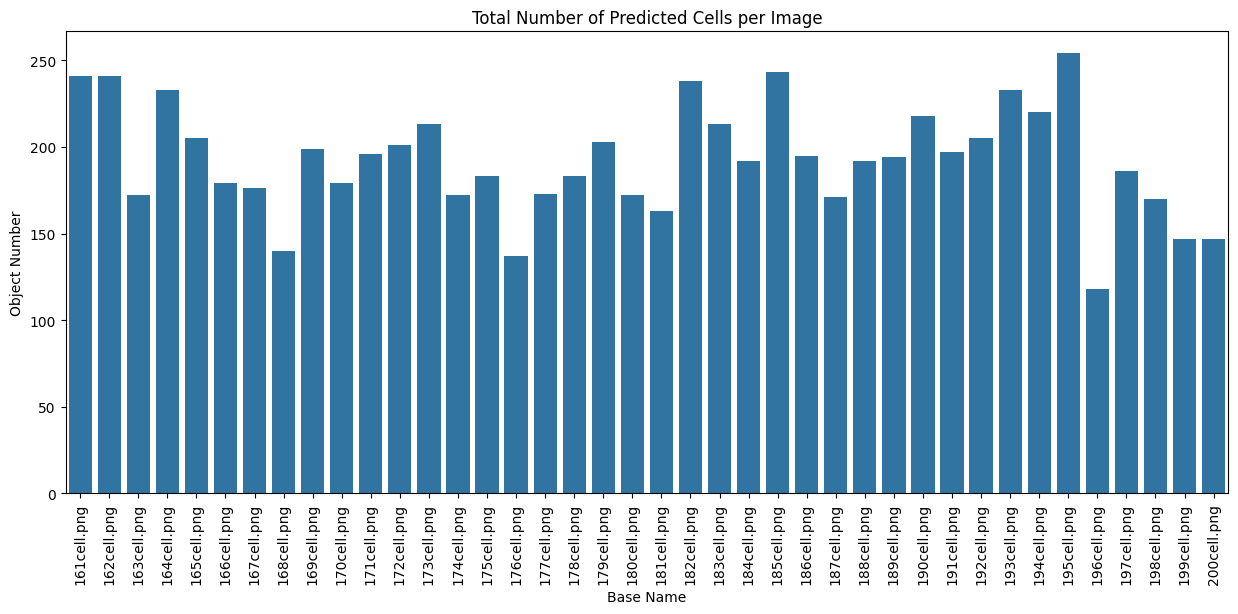

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the CSV file into a Pandas DataFrame
df = pd.read_csv("/content/drive/MyDrive/Final IDCC-SAM/Rebuttal/VGG/Mask RCNN/Test Results/test_segmentation_output/output_objects.csv")

# 1. number of Nuclei per image for each unique 'File Name'.
# Extract the base name from the file name (excluding the number)
df['Base Name'] = df['File Name'].str.rsplit('_', n=1).str[0]

# Group by the base name and compute the total number of non-empty object numbers per image
total_nuclei_per_base_name = df.groupby('Base Name')['Object Number'].apply(lambda x: (x != 0).sum()).reset_index()

# Plot the total number of non-empty object numbers per image
plt.figure(figsize=(15, 6))
sns.barplot(data=total_nuclei_per_base_name, x='Base Name', y='Object Number')
plt.title('Total Number of Predicted Cells per Image')
plt.xticks(rotation=90)
plt.show()


### Now let's analyze the predictions, compare it to ground truths, and save the prediction summary in an excel file

In [ ]:
import pandas as pd

# Load the CSV file into a Pandas DataFrame
df = pd.read_csv("/content/drive/MyDrive/Final IDCC-SAM/Rebuttal/VGG/Mask RCNN/Test Results/test_segmentation_output/output_objects.csv")

# Extract the base name from the file name (excluding the number)
df['Base Name'] = df['File Name'].str.rsplit('_', n=1).str[0]

# Group by the base name and compute the total number of non-empty object numbers per image
total_nuclei_per_base_name = df.groupby('File Name')['Object Number'].apply(lambda x: (x != 0).sum()).reset_index()
total_nuclei_per_base_name.columns = ['File Name', 'Total Nuclei']

# Load the ground truth Excel file
ground_truth_df = pd.read_csv('/content/drive/MyDrive/Final IDCC-SAM/Dataset/Rebuttal/VGG/ground_truth.csv')

# Merge the total nuclei counts with the ground truth data
merged_df = pd.merge(total_nuclei_per_base_name, ground_truth_df, left_on='File Name', right_on='image name')

# Calculate the absolute difference and absolute percentage accuracy
merged_df['Absolute Difference'] = (merged_df['Total Nuclei'] - merged_df['ground truth']).abs()
merged_df['Absolute Percentage Accuracy'] = (1 - merged_df['Absolute Difference'] / merged_df['ground truth']) * 100

# Rename columns and create the new column "AAE <=10"
merged_df.rename(columns={'Total Nuclei': 'Prediction', 'Absolute Difference': 'Raw Absolute Error'}, inplace=True)
merged_df['AAE <=10'] = merged_df['Raw Absolute Error'].apply(lambda x: 'Yes' if x <= 10 else 'No')

# Drop unnecessary columns
merged_df.drop(columns=['SN', 'image name'], inplace=True)

# Reorder columns
final_df = merged_df[['File Name', 'ground truth', 'Prediction', 'Raw Absolute Error', 'AAE <=10']]
final_df.rename(columns={'ground truth': 'Ground Truth', 'File Name': 'Image Name'}, inplace=True)
final_df = final_df.sort_values(by='Raw Absolute Error', ascending=True)

# Save the final DataFrame to a new prediction summary Excel file
summary_excel_path = '/content/drive/MyDrive/Final IDCC-SAM/Rebuttal/VGG/Mask RCNN/Mask RCNN_prediction_summary_VGG.xlsx'
final_df.to_excel(summary_excel_path, index=False)

# Display the final DataFrame
print(final_df)


     Image Name  Ground Truth  Prediction  Raw Absolute Error AAE <=10
12  173cell.png           212         213                   1      Yes
38  199cell.png           146         147                   1      Yes
2   163cell.png           166         172                   6      Yes
18  179cell.png           196         203                   7      Yes
24  185cell.png           233         243                  10      Yes
4   165cell.png           192         205                  13       No
25  186cell.png           209         195                  14       No
23  184cell.png           210         192                  18       No
3   164cell.png           213         233                  20       No
22  183cell.png           235         213                  22       No
36  197cell.png           211         186                  25       No
9   170cell.png           153         179                  26       No
1   162cell.png           268         241                  27       No
39  20

<ipython-input-26-a92bf56e6333>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df.rename(columns={'ground truth': 'Ground Truth', 'File Name': 'Image Name'}, inplace=True)


# END